# Optical flow Gaussian image denoising

In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
#from ipywidgets import *
import cv2
import time
#import kernels
from skimage import io as skimage_io
import information_theory  # pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [2]:
img = skimage_io.imread("http://www.hpca.ual.es/~vruiz/images/barb.png")

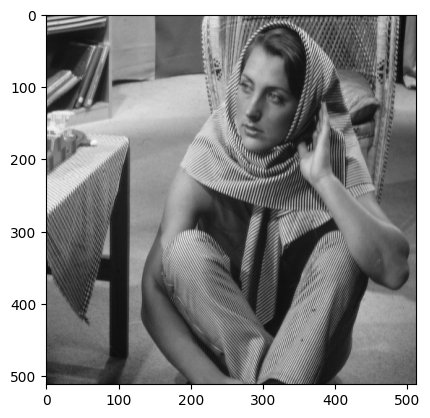

In [3]:
plt.imshow(img, cmap="gray")

In [4]:
mean = 0
var = 1000
sigma = var**0.5
noise = np.random.normal(mean,sigma,img.shape).reshape(img.shape)
noisy_img = np.clip(a=img.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

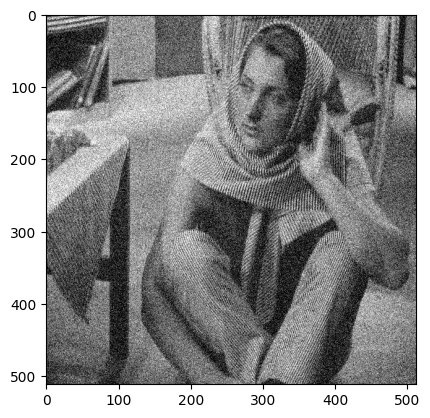

In [5]:
plt.imshow(noisy_img, cmap="gray")

In [ ]:
#import denoising.image.OF_gaussian as denoising
!pip install "image_denoising @ git+https://github.com/microscopy-processing/image_denoising"
!pip show image_denoising
import image_denoising
import logging
from image_denoising import OF_gaussian
image_denoising.OF_gaussian.logger.setLevel(logging.WARNING)
logging.getLevelName(image_denoising.OF_gaussian.logger.getEffectiveLevel())

In [ ]:
%%time

OFGD__sigma_kernel = 2.5
OFGD__N_iters = 1
OFGD__l = 1
OFGD__w = 9
OFGD__sigma_OF = 1.0

denoised_img, _ = image_denoising.OF_gaussian.filter_gray_image(noisy_img, OFGD__sigma_kernel, OFGD__N_iters, OFGD__l, OFGD__w, OFGD__sigma_OF)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy_img, cmap="gray")
axs[1].set_title("Noisy")
axs[2].imshow(denoised_img, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.avg_PSNR(denoised_img, img):4.2f} dB)")
fig.tight_layout()
plt.show()

In [6]:
import denoising.image.OF_gaussian as denoising

In [7]:
import logging

In [8]:
sigma = 2.0

In [9]:
denoiser = denoising.Monochrome_Denoising(verbosity=logging.DEBUG, sigma_poly=4.0, sigma_flow=4.0, pyr_levels=2)
#denoiser = gaussian_denoising.Monochrome_Image_OF_Gaussian_Denoising(sigma_gaussian=sigma_gaussian, l=3, w=5, sigma_OF=1.0, verbosity=logging.DEBUG)

[OF_gaussian.py:36 __init__()] sigma_poly=4.0
[OF_gaussian.py:37 __init__()] sigma_flow=4.0
[OF_gaussian.py:38 __init__()] pyr_levels=2


[gaussian.py:40 get_kernel()] sigma=2.0


[6.69162896e-05 4.36349021e-04 2.21596317e-03 8.76430436e-03
 2.69959580e-02 6.47599366e-02 1.20987490e-01 1.76035759e-01
 1.99474648e-01 1.76035759e-01 1.20987490e-01 6.47599366e-02
 2.69959580e-02 8.76430436e-03 2.21596317e-03 4.36349021e-04
 6.69162896e-05]
1.0


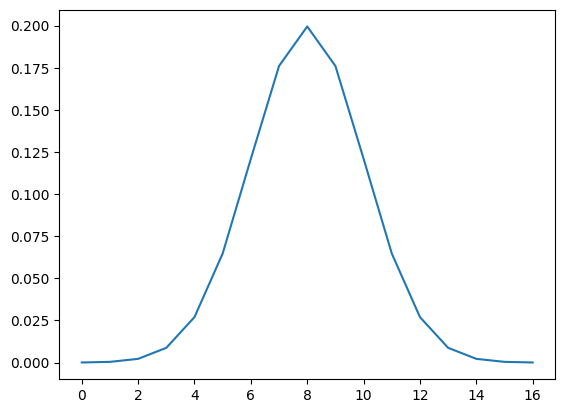

In [10]:
kernel = denoiser.get_kernel(sigma)
print(kernel)
print(np.sum(kernel))
plt.plot(kernel)
plt.show()

[gaussian.py:127 filter_iterate()] sigma=2.0
[gaussian.py:40 get_kernel()] sigma=2.0


0 Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
14.146353733491475
7.926345058819564
7.968521620318817
9.931854676809811
8.923195506974803
8.373317750364507
9.711700928467781
9.755295149251788
9.513746599261333
1 Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
14.146353733491475
7.926345058819564
7.968521620318817
9.931854676809811
8.923195506974803
8.373317750364507
9.711700928467781
9.755295149251788
9.513746599261333
9.99088023245073
2 Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Caught LinAlgError: Singular matrix
Cau

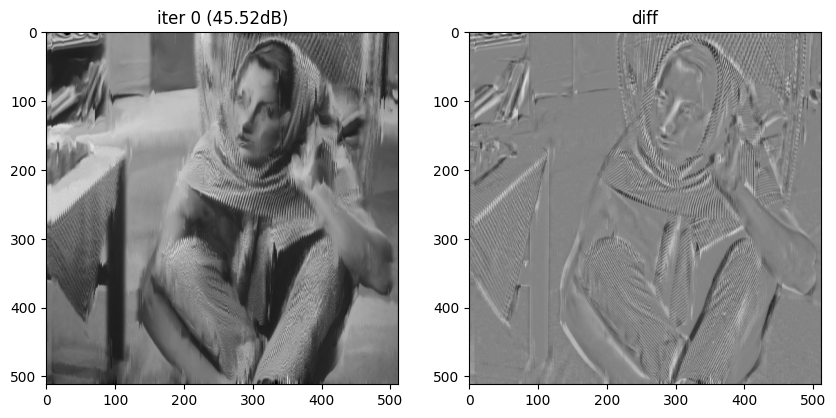

[OF_gaussian.py:42 filter_iterate()] Number of singular matrices = 218
[OF_gaussian.py:43 filter_iterate()] sigma_poly=4.0
[OF_gaussian.py:44 filter_iterate()] sigma_flow=4.0
[OF_gaussian.py:45 filter_iterate()] pyr_levels=2


In [11]:
denoised_img, _ = denoiser.filter_iterate(noisy_img=img, GT=img, sigma=sigma)

In [12]:
denoised_img = np.clip(denoised_img, a_min=0, a_max=255)

41.86757027262087
46.67423810030474
48.02810343113325


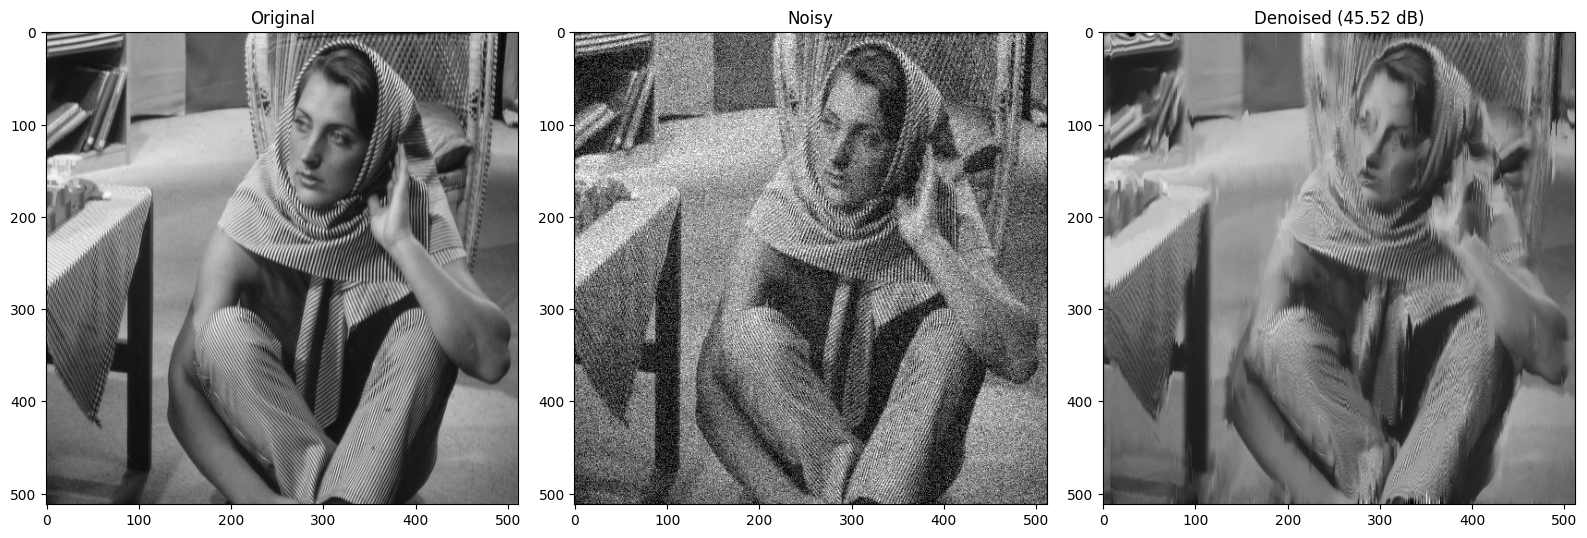

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy_img, cmap="gray")
axs[1].set_title("Noisy")
axs[2].imshow(denoised_img, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.avg_PSNR(denoised_img, img):4.2f} dB)")
fig.tight_layout()
plt.show()

In [ ]:
img = skimage_io.imread("http://www.hpca.ual.es/~vruiz/images/lena.png")

In [ ]:
plt.imshow(img)

In [ ]:
mean = 0
var = 1000
sigma = var**0.5
noise = np.random.normal(mean,sigma,img.shape).reshape(img.shape)
noisy_img = np.clip(a=img.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

In [ ]:
plt.imshow(noisy_img)

In [ ]:
sigma_gaussian = 2.0

In [ ]:
denoiser = gaussian_denoising.Color_Image_OF_Gaussian_Denoising(
    sigma_gaussian=sigma_gaussian, l=3, w=5, sigma_OF=1.0, verbosity=logging.DEBUG)

In [ ]:
denoised_img, _ = denoiser.filter(noisy_image=noisy_img, GT=img)
denoised_img = denoised_img.astype(np.uint8)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(img)
axs[0].set_title("Original")
axs[1].imshow(noisy_img)
axs[1].set_title("Noisy")
axs[2].imshow(denoised_img)
axs[2].set_title("Denoised")
fig.tight_layout()
plt.show()